# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [28]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-07 19:55:57--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-07 19:55:57--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip.3’

data.zip.3          100%[===================>]  36.61M  --.-KB/s    in 0.1s    

2023-12-07 19:55:57 (297 MB/s) - ‘data.zip.3’ saved [38392108/38392108]

replace data/class_dict? [y]es, [n]o, [A]ll

# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [29]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
import torch.nn.functional as F
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

In [30]:
def get_xml_data(image_path, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_path.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        card_suit = member.find("name").text
        xmin = int(member.find("bndbox/xmin").text)
        ymin = int(member.find("bndbox/ymin").text)
        xmax = int(member.find("bndbox/xmax").text)
        ymax = int(member.find("bndbox/ymax").text)
        ymax = int(member.find("bndbox/ymax").text)
        res = [xmin, ymin, xmax, ymax, class_dict[card_suit]]
        bboxes.append(res)
    return bboxes

In [31]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = np.array(Image.open(fname))
        bboxes = get_xml_data(fname, self.root, self.class_dict)
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.class_dict_inv)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [32]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [33]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [34]:
from matplotlib import patches

def visualize(images, bboxes):
    mean = torch.tensor((0.485, 0.456, 0.406))
    std = torch.tensor((0.229, 0.224, 0.225))

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    unnormalized_images = []

    for image in images:
        image = torch.permute(image, dims=(1, 2, 0))
        unnormalized_images.append(
            torch.add(torch.mul(image, std), mean)
        )
    # https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3

    for i, ax in enumerate(axes.reshape(-1)):
        ax.axis(False)
        if i >= len(images):
            break

        ax.imshow(unnormalized_images[i])

        for bbox in bboxes[i]:
          xmin, ymin, xmax, ymax = bbox[:4]
          ax.add_patch(
              Rectangle(
                  (xmin, ymin),
                  xmax, ymax,
                  linewidth=1,
                  edgecolor='r',
                  facecolor='none'
              )
          )
          # https://stackoverflow.com/questions/37435369/how-to-draw-a-rectangle-on-image
          ax.text(xmin, ymin, train_ds.class_dict_inv[bbox[4]], color='y')

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

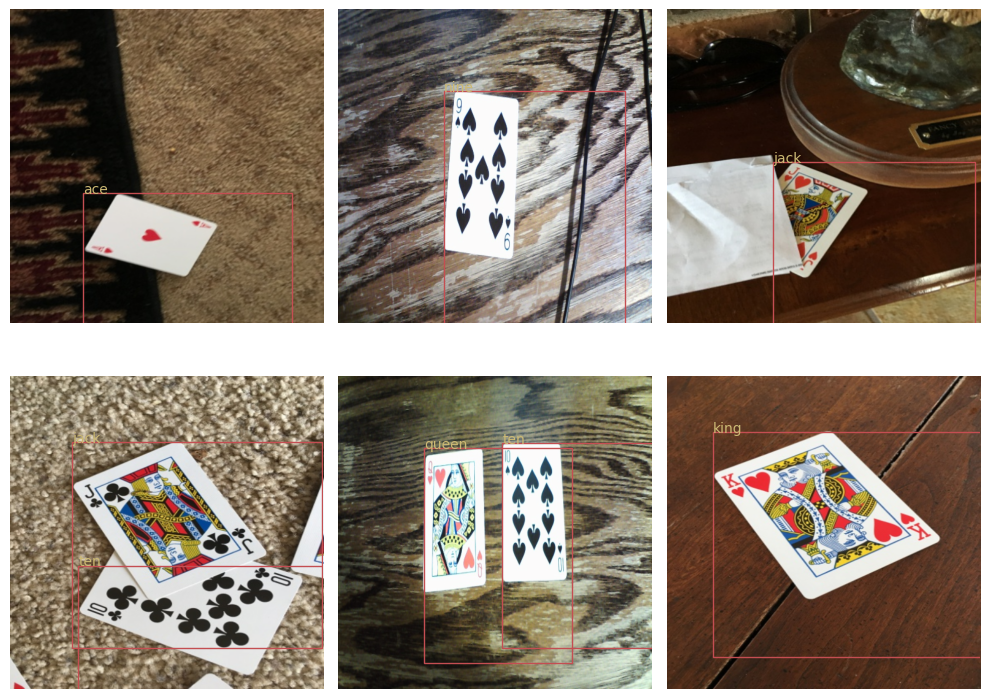

In [35]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO

Сейчас нам предстоить реализовать YOLO детектор. Это один из самых простых детекторов с точки зрения реализации. Он описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Мы будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16. В каждом пикселе мы будем предсказывать размеры прямоугольника и класс.



We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности. В каналах у нас будут записаны координаты центра, центр относительно координат пикселя, бинарная переменная (детекция присутствует), класс детекции.

In [36]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = xmax - xmin # размер клетки по X в пикс
        y_cell = ymax - ymin # размер клетки по Y в пикс
        w_box = x_cell / w # ширина бокса отнормированная
        h_box = y_cell / h # высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx = (xmax + xmin) / 2 # (координаты центра в исходных координатах)
        cy = (ymax + ymin) / 2
        cx_idx = (cx // downsample).long() # (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx = (cy // downsample).long()

        cx_box = cx % downsample / downsample # (посчитайте сдивиги относительно cx_idx)
        cy_box = cy % downsample / downsample

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

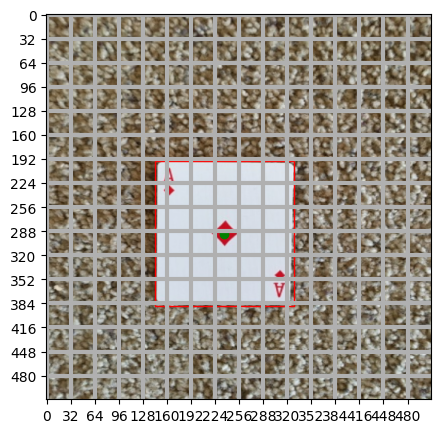

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Реализуйте аналогичные принципы, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами.

То есть, нужно проделать операции из collate_fn в обратную сторону.

In [58]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample

    decoded_predictions = []
    # итерируемся по батчам
    for i in range(b):
        decoded_bboxes = []

        # итерируемся по каждому пикселю декодированного предсказания
        for y in range(h):
            for x in range(w):
                pred_yx = pred[i, :, y, x] # берём предсказание для конкретной клетки

                if pred_yx[4] > threshold:
                    # проводим обратную нормализацию
                    cx_cell, cy_cell = pred_yx[0], pred_yx[1]
                    cx, cy = upsample * (cx_cell + x), upsample * (cy_cell + y)
                    bbox_height, bbox_width = pred_yx[2] * img_h, pred_yx[3] * img_w

                    # вычисляем координаты
                    xmin = cx - (bbox_width / 2)
                    xmax = cx + (bbox_width / 2)
                    ymin = cy - (bbox_height / 2)
                    ymax = cy + (bbox_height / 2)

                    class_pred = pred_yx[5:].numpy()
                    decoded_bboxes.append((xmin, ymin, xmax, ymax, np.argmax([class_pred])))

        decoded_predictions.append(decoded_bboxes)
    return decoded_predictions

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 вклюяительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [39]:
with open('/content/data/class_dict', 'r') as f:
    C = len(eval(f.readline())) # Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # берём первые 4 блока
        self.resnet_blocks = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )
        # добавляем доп слои
        self.layers_addition = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1)
        )

    def forward(self, img):
      # forward pass
        x = self.resnet_blocks(img)
        x = self.layers_addition(x)
        x = F.interpolate(x, size=(16, 16), mode='bilinear', align_corners=False)
        x = torch.sigmoid(x)

        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)

* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [40]:
from torch.nn import BCELoss, CrossEntropyLoss, MSELoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
def class_loss(pred, target, num_classes):
    # делаем маску у выбранным элементам, где таргет положительный
    masking = (target > 0).unsqueeze(1).expand_as(pred)

    spred = torch.masked_select(pred, masking)
    starget = target[target > 0]
    spred = spred.view(-1, num_classes)
    # вычисляем лосс
    classification_loss = F.cross_entropy(spred, starget.long(), reduction='sum')
    return classification_loss

In [42]:
def special_loss(pred, target, check=False, C=C):
    # localization loss
    # создаём маску
    loc_mask = target[:, :2, :, :] > 0
    # применяем маску
    masked_target = torch.masked_select(target[:, :2, :, :], loc_mask)
    masked_pred = torch.masked_select(pred[:, :2, :, :], loc_mask)
    # вычисляем лосс
    loss = MSELoss(reduction='sum')
    localization_loss = loss(masked_target, masked_pred)


    # box loss
    # создаём маску
    box_mask = target[:, 2:4, :, :] > 0
    # применяем маску
    masked_target_box = torch.masked_select(target[:, 2:4, :, :], box_mask)
    masked_pred_box = torch.masked_select(pred[:, 2:4, :, :], box_mask)
    # вычисляем лосс
    loss = MSELoss(reduction='sum')
    box_loss = loss(torch.sqrt(masked_target_box), torch.sqrt(masked_pred_box))


    # classification loss
    # извлекаем оценки класса (для предсказаний) и меток (для таргета)
    class_pred = pred[:, 5:, :, :]
    class_target = target[:, 5, :, :]

    classification_loss = class_loss(class_pred, class_target, C)


    # binary cross-entropy

    confidence_losses = []  # список для хранения confidence loss
    detection_mask = target[:, 4, :, :] > 0
    # итерируемся по каждому пикселю и вычисляем confidence loss
    for i in range(pred.size(2)):  # высота для предсказания
        for j in range(pred.size(3)):  # ширина для предсказания
            if detection_mask[:, i, j].any(): # все картинки из батча, их высота и ширина
                # обнаруженные объекты: вес 1.0
                weight = torch.tensor(1.0)
            else:
                # обнаруженные объекты: вес 0.1
                weight = torch.tensor(0.1)

            loss = BCELoss(
                weight=weight,
                reduction='sum'
            )
            confidence_losses.append(loss(
                pred[:, 4, i, j],
                target[:, 4, i, j]
            ))

    # stacking confidence losses
    confidence_loss = torch.stack(confidence_losses).sum()

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss
    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [43]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [46]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(666)
EPOCHS = 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        images, targets = batch['image'], batch['target']
        images, targets = images.to(device), targets.to(device)

        # forward pass
        predictions = model(images)

        # calculating loss
        loss = special_loss(predictions.cpu(), targets.cpu())

        # backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0 done; Train loss 140.887;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 done; Train loss 117.465;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2 done; Train loss 98.738;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3 done; Train loss 83.413;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4 done; Train loss 72.413;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5 done; Train loss 62.227;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6 done; Train loss 55.949;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7 done; Train loss 50.763;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8 done; Train loss 46.393;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9 done; Train loss 42.720;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10 done; Train loss 39.503;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11 done; Train loss 36.643;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12 done; Train loss 34.107;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13 done; Train loss 31.847;


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14 done; Train loss 29.813;


Запустим обученный детектор на тестовых изображениях:

In [48]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [49]:
# Нужно сделать предсказание и переложить результат на cpu

# setting to evaluation mode
model.eval()

# getting a batch for making a prediction
images, _ = batch['image'].to(device), batch['target'].to(device)

# making predictions and storing them on cpu
with torch.no_grad():
    predictions = model(images)

predictions = predictions.cpu()

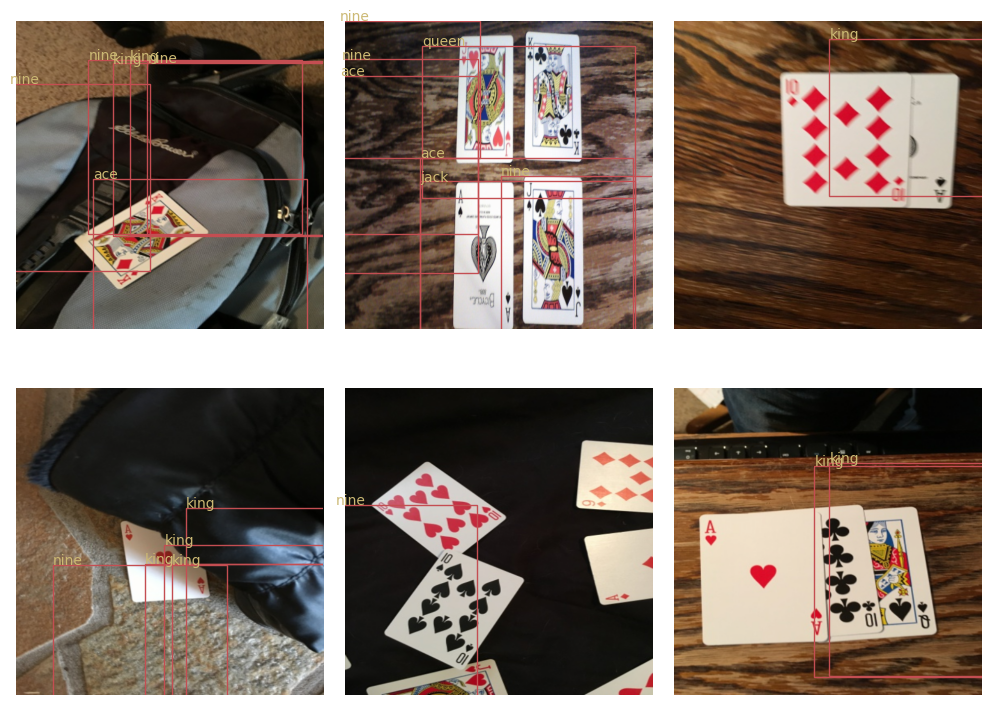

In [50]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

decoded_predictions = decode_prediction(predictions, threshold=0.44)
visualize(
    [images[i].cpu() for i in range(6)],
    [decoded_predictions[i] for i in range(6)]
)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [51]:
!pip install ultralytics

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [52]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [53]:
def annotation2txt(bboxes, w_im, h_im):
    # для хранения аннотаций
    text_annotations = []

    # итерируемся по всем bboxes
    for bbox in bboxes:
        xmin, ymin, xmax, ymax, card_suit = bbox
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        width = xmax - xmin
        height = ymax - ymin
        x_center /= w_im
        y_center /= h_im
        width /= w_im
        height /= h_im

        # добавляем аннотации
        text_annotations.append(f"{card_suit} {x_center} {y_center} {width} {height}")

    return text_annotations

In [54]:
# Копируем картиночки по папочкам и создаем txt файлики
for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [55]:
# Собираем YAML
with open('/content/data/class_dict', 'r') as f:
    names = list(eval(f.readline()))
    nc = len(names)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [59]:
import ultralytics
# Загрузить модель
model = ultralytics.YOLO('yolov8n.yaml')
# загрузить предобученную модель (рекомендуется для обучения)

# Обучить модель с использованием 2 GPU
results = model.train(data='data.yaml', epochs=EPOCHS, imgsz=480, device=device)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

train: Scanning /content/train/labels.cache... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 6 images, 0 backgrounds, 1 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/valid/images/cam_image38.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.7209      1.1534       1.713      1.1389]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 480 train, 480 val
Using 2 dataloader workers
Logging results to runs/detect/train7
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      2.35G      2.624      4.737      4.635         17        480: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

                   all          5         12   0.000926     0.0417    0.00152   0.000152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      1.99G      3.439      4.762      4.572         18        480: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all          5         12   0.000926     0.0417     0.0029    0.00029



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      1.98G      3.526      4.815      4.701         20        480: 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all          5         12   0.000926     0.0417     0.0023    0.00023



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      1.97G       4.01      4.712      4.509         22        480: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all          5         12   0.000926     0.0417    0.00063    6.3e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      1.97G      3.184      4.657      4.454         13        480: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.98it/s]

                   all          5         12   0.000926     0.0417     0.0106    0.00106


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      1.97G      2.676      5.108      4.959          8        480: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all          5         12   0.000926     0.0417     0.0106    0.00106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      1.97G      2.939      5.012      4.629          8        480: 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


                   all          5         12   0.000926     0.0417     0.0208    0.00208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      1.99G       3.04      5.158      5.079          8        480: 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all          5         12   0.000952     0.0417    0.00853   0.000853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      1.99G      2.139      4.817      4.625          8        480: 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]

                   all          5         12   0.000952     0.0417    0.00547   0.000547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      1.99G      2.459      5.187      5.124          8        480: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.64it/s]

                   all          5         12   0.000952     0.0417    0.00138   0.000138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      1.99G      2.301      4.754      4.717          8        480: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.88it/s]

                   all          5         12   0.000952     0.0417    0.00214   0.000214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      1.99G        3.1      4.786      4.899          8        480: 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.04it/s]

                   all          5         12   0.000952     0.0417    0.00168   0.000168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      1.99G      2.877      5.221      5.099          8        480: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]

                   all          5         12    0.00098     0.0417    0.00165   0.000165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      1.99G      2.815       5.05      4.594          8        480: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.81it/s]

                   all          5         12    0.00098     0.0417    0.00142   0.000142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      1.99G      2.665        4.6      4.803          8        480: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]

                   all          5         12    0.00101     0.0417    0.00447   0.000447



15 epochs completed in 0.004 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 6.2MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


                   all          5         12   0.000926     0.0417     0.0208    0.00208
                  king          5          1          0          0          0          0
                  jack          5          1          0          0          0          0
                   ace          5          4          0          0          0          0
                   ten          5          4    0.00556       0.25      0.125     0.0125
                  nine          5          1          0          0          0          0
                 queen          5          1          0          0          0          0
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train7


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [65]:
results = model.predict(source="/content/valid/images", save=True, plots=True)
# Обработка генератора результатов
for result in results:
    boxes = result.boxes  # Объект Boxes для вывода bbox
    masks = result.masks  # Объект Masks для вывода масок сегментации
    keypoints = result.keypoints  # Объект Keypoints для вывода поз
    probs = result.probs  # Объект Probs для вывода вероятностей классификации


image 1/6 /content/valid/images/IMG_2440.JPG: 480x384 (no detections), 19.5ms
image 2/6 /content/valid/images/IMG_2546.JPG: 480x384 (no detections), 19.1ms
image 3/6 /content/valid/images/IMG_2611.JPG: 480x384 (no detections), 16.9ms
image 4/6 /content/valid/images/IMG_2647.JPG: 480x384 (no detections), 22.9ms
image 5/6 /content/valid/images/IMG_2648.JPG: 480x384 (no detections), 17.5ms
image 6/6 /content/valid/images/cam_image38.jpg: 288x480 (no detections), 13.4ms
Speed: 5.1ms preprocess, 18.2ms inference, 2.6ms postprocess per image at shape (1, 3, 288, 480)
Results saved to runs/detect/train76
